### Описание проекта
Вы — маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несмотря на огромные вложения в рекламу, последние несколько месяцев компания терпит убытки. Ваша задача — разобраться в причинах и помочь компании выйти в плюс.

Есть данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* лог сервера с данными об их посещениях,
* выгрузка их покупок за этот период,
* рекламные расходы.

Вам предстоит изучить:
* откуда приходят пользователи и какими устройствами они пользуются,
* сколько стоит привлечение пользователей из различных рекламных каналов;
* сколько денег приносит каждый клиент,
* когда расходы на привлечение клиента окупаются,
* какие факторы мешают привлечению клиентов.

### Описание данных
В вашем распоряжении три датасета. Файл visits_info_short.csv хранит лог сервера с информацией о посещениях сайта, orders_info_short.csv — информацию о заказах, а costs_info_short.csv — информацию о расходах на рекламу.

Структура visits_info_short.csv:
* User Id — уникальный идентификатор пользователя,
* Region — страна пользователя,
* Device — тип устройства пользователя,
* Channel — идентификатор источника перехода,
* Session Start — дата и время начала сессии,
* Session End — дата и время окончания сессии.

Структура orders_info_short.csv:
* User Id — уникальный идентификатор пользователя,
* Event Dt — дата и время покупки,
* Revenue — сумма заказа.

Структура costs_info_short.csv:
* dt — дата проведения рекламной кампании,
* Channel — идентификатор рекламного источника,
* costs — расходы на эту кампанию.

## 1. Загрузите данные и подготовьте их к анализу

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt


In [4]:
try:
    visits = pd.read_csv('/datasets/visits_info_short.csv')
    orders = pd.read_csv('/datasets/orders_info_short.csv')
    costs = pd.read_csv('/datasets/costs_info_short.csv')
except:
    visits = pd.read_csv('https://code.s3.yandex.net//datasets/visits_info_short.csv')
    orders = pd.read_csv('https://code.s3.yandex.net//datasets/orders_info_short.csv')
    costs = pd.read_csv('https://code.s3.yandex.net//datasets/costs_info_short.csv')

In [5]:
visits.head()

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40


In [6]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


In [7]:
visits.duplicated().sum() # явных дубликатов нет

0

Таблица visits: на 309901 строк , 6 столбцов. 
* пропущенных значений нет
* явных дубликатов нет
* названия полей состоят из двух слов c заглавной буквы (заменю на snake_case)
* поля Session Start и Session End имеют тип object (заменю тип на datetime, чем они по сути и являются)

In [8]:
visits.columns = visits.columns.str.replace(' ', '_').str.lower() # столбцы в snake_case
visits[['session_start', 'session_end']] = visits[['session_start', 'session_end']].apply(pd.to_datetime) # тип столбцов к datetime
visits.sample()

,user_id,region,device,channel,session_start,session_end
257707,858752147535,France,iPhone,LeapBob,2019-08-08 09:19:54,2019-08-08 09:40:05


In [9]:
orders.head()

,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99


In [10]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


In [11]:
orders.duplicated().sum() # явных дубликатов нет

0

Таблица orders: на 40212 строк, три столбца
* явных дубликатов нет
* пропущенных значений нет
* поле Event DT dtypes: object (заменю на datetime)
* названия полей из двух слов с заглавных букв, в shake_case

In [12]:
orders.columns = orders.columns.str.replace(' ', '_').str.lower() # столбцы в snake_case
orders['event_dt'] = pd.to_datetime(orders['event_dt']) # тип столбца к datetime
orders.sample()

,user_id,event_dt,revenue
25997,283298432575,2019-10-22 15:03:58,4.99


In [13]:
costs.head()

,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1


In [14]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


In [15]:
costs.duplicated().sum() # явных дубликатов нет

0

Таблица costs: 1800 строк, 3 столбца
* пропущенных значений нет
* явных дубликатов нет 
* названия полей (приведу к нижнему регистру)
* Поле dt имеет тип object(приведу к datetime, data)

In [16]:
costs.columns = costs.columns.str.lower() # столбцы в нижний регистр
costs['dt'] = pd.to_datetime(costs['dt']).dt.date
costs.sample()

,dt,channel,costs
1070,2019-10-18,AdNonSense,22.05


#### Вывод:
* Три таблицы visits, orders, costs 
* Явных дубликатов нет 
* Заменили названия столбцов на snake_case
* Привели столбцы dt, event_dt, session_start, session_end к типу datetime

## 2. Задайте функции для расчёта и анализа LTV, ROI, удержания и конверсии.

In [17]:
# редактирую под нужды проекта
# функция для создания пользовательских профилей

def get_profiles(visits, orders, costs):
    
    # находим параметры первых посещений
    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

     #объединяем траты на рекламу и число привлечённых пользователей
    costs = costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    costs['acquisition_cost'] = costs['costs'] / costs['unique_users']

    #добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles


In [18]:
# функция для расчёта удержания

def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [19]:

# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time

In [20]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )

In [21]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [22]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show()

In [23]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [24]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

## 3. Исследовательский анализ данных
* Составьте профили пользователей. Определите минимальную и максимальную даты привлечения пользователей.
* Выясните, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих из каждой страны.
* Узнайте, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
* Изучите рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Постройте таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.
* После каждого пункта сформулируйте выводы.


In [25]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [26]:
min_analysis_date = profiles['first_ts'].min()
max_analysis_date = profiles['first_ts'].max()
print(f'Минимальная дата привлечения пользоваелей: {min_analysis_date}')
print(f'Максимальная дата привлечения пользоваелей: {max_analysis_date}')

Минимальная дата привлечения пользоваелей: 2019-05-01 00:00:41
Максимальная дата привлечения пользоваелей: 2019-10-27 23:59:04


In [27]:
paying_country_users = profiles.groupby('region').agg({'user_id': 'nunique', 'payer':['sum', 'mean']})
paying_country_users.columns = ['пользователи', 'платящие_пользователи', 'доля_платящих']
paying_country_users.sort_values(by= 'пользователи', ascending = False).style.format({'доля_платящих': '{:.2%}'})

,пользователи,платящие_пользователи,доля_платящих
region,,,
United States,100002,6902,6.90%
UK,17575,700,3.98%
France,17450,663,3.80%
Germany,14981,616,4.11%


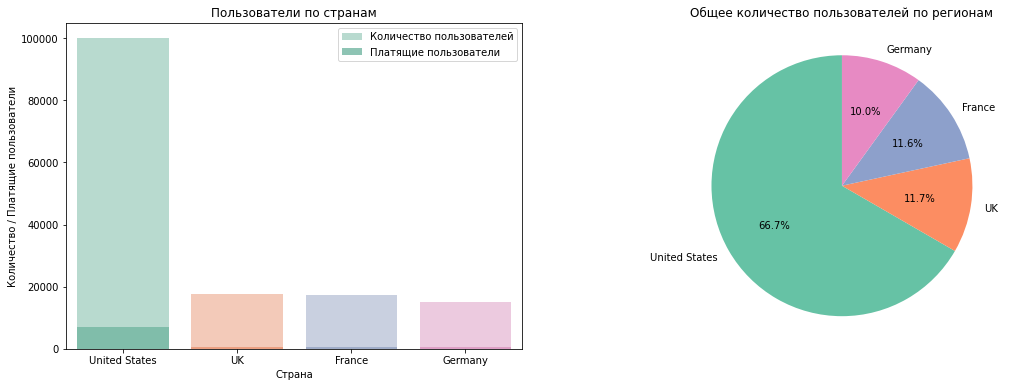

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))

# первый график
sns.barplot(x=paying_country_users.sort_values(by='пользователи', ascending=False).index, 
            y='пользователи', data=paying_country_users.sort_values(by='пользователи', ascending=False), 
            ax=ax1, alpha=0.5, label='Количество пользователей', palette='Set2')

sns.barplot(x=paying_country_users.sort_values(by='пользователи', ascending=False).index, 
            y='платящие_пользователи', data=paying_country_users.sort_values(by='пользователи', ascending=False), 
            ax=ax1, alpha=0.8, label='Платящие пользователи', palette='Set2')

ax1.legend()
ax1.set_xlabel('Страна')
ax1.set_ylabel('Количество / Платящие пользователи')
ax1.set_title('Пользователи по странам')

# второй график
pie = profiles['region'].value_counts()
labels = pie.index.tolist()
sizes = pie.values.tolist()

ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
ax2.set_title('Общее количество пользователей по регионам')

plt.show()

* Больше всего пользователей в приложение приходит из US также из этой страны больше всего платящих пользователей и самая высокая доля платящих к простым пользователям.
* На втором месте пользователи которые приходят с UK, а также платящих пользователей. Хотя доля платящих чуть выше у Germany.
* На третьем месте France как пользователям так и по платящим пользователям, хотя доля платящих самая маленькая.
* На четвертом месте Germany, с высокой долей платящих пользователей, но маленьким числом как простых пользователей, так и платящих. Но обратим на это внимание.

In [29]:
devices_users = profiles.groupby('device').agg({'user_id': 'nunique', 'payer':['sum', 'mean']})
devices_users.columns = ['пользователи', 'платящие_пользователи', 'доля_платящих']
devices_users.sort_values(by='пользователи', ascending=False).style.format({'доля_платящих': '{:.2%}'})

,пользователи,платящие_пользователи,доля_платящих
device,,,
iPhone,54479,3382,6.21%
Android,35032,2050,5.85%
PC,30455,1537,5.05%
Mac,30042,1912,6.36%


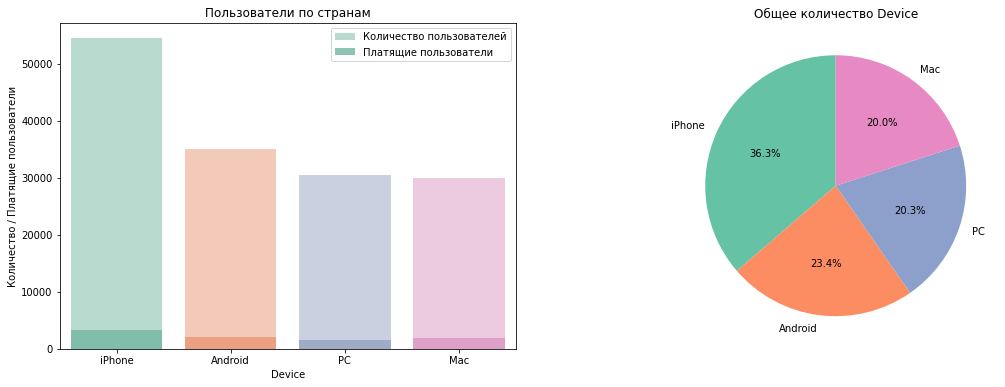

In [30]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,6))

# первый график
sns.barplot(x=devices_users.sort_values(by='пользователи', ascending=False).index, 
            y='пользователи', data=devices_users.sort_values(by='пользователи', ascending=False), 
            ax=ax1, alpha=0.5, label='Количество пользователей', palette='Set2')

sns.barplot(x=devices_users.sort_values(by='пользователи', ascending=False).index, 
            y='платящие_пользователи', data=devices_users.sort_values(by='пользователи', ascending=False), 
            ax=ax1, alpha=0.8, label='Платящие пользователи', palette='Set2')

ax1.legend()
ax1.set_xlabel('Device')
ax1.set_ylabel('Количество / Платящие пользователи')
ax1.set_title('Пользователи по странам')

# второй график
pie = profiles['device'].value_counts()
labels = pie.index.tolist()
sizes = pie.values.tolist()

ax2.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Set2'))
ax2.set_title('Общее количество Device')

plt.show()

* Больше всех в приложение заходят пользователи IPhone, также среди них больше всего платящих пользователей, хотя доля платящих чуть меньше чем у платформы Мас.
* На втором месте пользователи Android, по пользователям и платящим пользователям, но по доли платящих на 3 месте (так как на втором IPhone)
* На третьем месте по пользователям и платящим пользователям PC, но доля платящих пользователей самая низкая.
* Ну и на четвертом месте Mac, хотя доля платящих самая высокая

In [31]:
channel_users = profiles.groupby('channel').agg({'user_id': 'nunique', 'payer':['sum', 'mean']})
channel_users.columns = ['пользователи', 'платящие_пользователи', 'доля_платящих']
channel_users.sort_values(by='пользователи', ascending=False).style.format({'доля_платящих': '{:.2%}'})

,пользователи,платящие_пользователи,доля_платящих
channel,,,
organic,56439,1160,2.06%
FaceBoom,29144,3557,12.20%
TipTop,19561,1878,9.60%
OppleCreativeMedia,8605,233,2.71%
LeapBob,8553,262,3.06%
WahooNetBanner,8553,453,5.30%
RocketSuperAds,4448,352,7.91%
MediaTornado,4364,156,3.57%
YRabbit,4312,165,3.83%


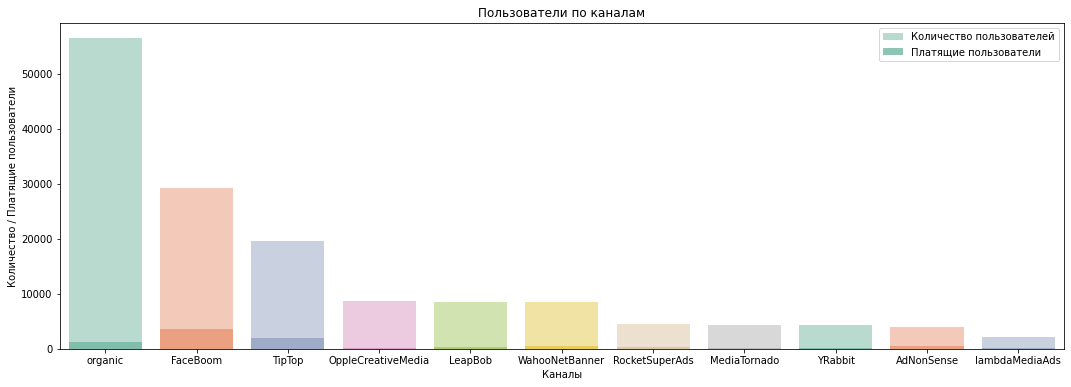

In [32]:
fig, ax = plt.subplots(figsize=(18, 6))

sns.barplot(
    x=channel_users.sort_values(by='пользователи', ascending=False).index, 
    y='пользователи', data=channel_users.sort_values(by='пользователи', ascending=False), 
    ax=ax, alpha=0.5, label='Количество пользователей', palette='Set2'
    )
sns.barplot(
    x=channel_users.sort_values(by='пользователи', ascending=False).index, 
    y='платящие_пользователи', data=channel_users.sort_values(by='пользователи', ascending=False), 
    ax=ax, alpha=0.8, label='Платящие пользователи', palette='Set2'
    )

ax.legend()
ax.set_xlabel('Каналы')
ax.set_ylabel('Количество / Платящие пользователи')
ax.set_title('Пользователи по каналам')

plt.show()

* Больше всего переходов конечно с organic, платящих пользователей тоже достаточно из всех каналов органичные платящие на 3 месте. Но доля платящих самая низкая.(Хотя на их привлечение напрямую, мы не несем затрат)
* На втором месте канал FaceBoom как по привлечённым пользователям, так и по платящим. Доля платящих самая высокая из всех каналов.
* На третьем месте канал TipTop, хотя по доле платящих он не входит в тройку.
* Здесь обратим внимание на каналы которые привлекли немного пользователей, но доля платящих высока AdNonSense, lambdaMediaAds и RocketSuperAds.


### Вывод:
* Страна  US с самыми высокими показателями как пользователей, так и платящих и по доле платящих. И эта страна на порядок опережает ближайшую.
* UK, France, Germany у этих стран показатели разнятся на десятые доли процента
и не так существенны на первый взгляд. Но всё-таки пользователи Germany платят лучше, чем UK или France.(Почему их самое маленькое количество.)
* Так как у нас страна с самымыми высокими показателями US, то и devaice распределены в соотвествии, на первом месте IPhone существенно превосходя ближайщего как по пользователям так и по платящим.
* Отметим платформу Mac переходов с нее в количественном выражении на последнем месте, но доля платящих самая высокая среди всех платформ.
* Android тоже занимает лидирующие позиции. Вообще переход с телефонов самый количественный и в духе времени.
* Замыкает PC. 
* С каналами тоже не все однозначно только FaceBoom и TipTop приводят много пользователей и у них высокий процент доли платящих.Есть каналы, которые привели мало пользователей, но среди них хороший процент платящих(AdNonSense, RocketSuperAds, lambdaMediaAds). Есть каналы, где показатели привлечения не плохие, а процент платящих низкий(OppleCreativeMedia, LeapBob). Здесь наверно нужно смотреть на распределение бюджета по каналам на привлечение.

## 4. Маркетинг
* Посчитайте общую сумму расходов на маркетинг.
* Выясните, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
* Постройте визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику. Постарайтесь отразить это на одном графике.
* Узнайте, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. Используйте профили пользователей.

In [33]:
print(f"Общая сумма расходов на маркетинг составляет: {costs['costs'].sum().round(2):.2f}")

Общая сумма расходов на маркетинг составляет: 105497.30


Посмотрим на распределение этой суммы по каналам привлечения.

In [34]:
advertising_costs = costs.groupby('channel').agg({'costs': ['sum']})
advertising_costs.columns = ['Сумма']
advertising_costs['Доля %'] = round(advertising_costs['Сумма'] / 105497.30 * 100, 1)
advertising_costs = advertising_costs.reset_index()
advertising_costs.sort_values(by='Сумма', ascending=False)

,channel,Сумма,Доля %
6,TipTop,54751.30,51.9
1,FaceBoom,32445.60,30.8
7,WahooNetBanner,5151.00,4.9
0,AdNonSense,3911.25,3.7
4,OppleCreativeMedia,2151.25,2.0
5,RocketSuperAds,1833.00,1.7
2,LeapBob,1797.60,1.7
9,lambdaMediaAds,1557.60,1.5
3,MediaTornado,954.48,0.9
8,YRabbit,944.22,0.9


In [35]:
top_channel = costs.groupby('channel')['costs'].sum().sort_values(ascending=False)[:4]
others = costs.groupby('channel')['costs'].sum().sort_values(ascending=False)[4:].sum()
top_channel_others = pd.concat([top_channel, pd.Series(others, index=['Other'])])

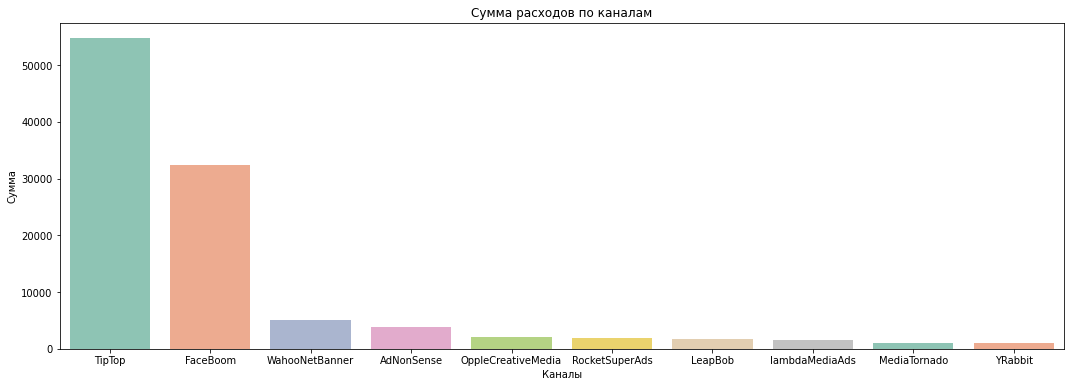

In [36]:
plt.figure(figsize=(18, 6))
sns.barplot(
    y='Сумма', x='channel', 
    data=advertising_costs.sort_values(by='Сумма', 
    ascending=False),
    alpha=0.8, palette='Set2'
    )

plt.title('Сумма расходов по каналам')
plt.xlabel('Каналы')
plt.ylabel('Сумма')
plt.show()

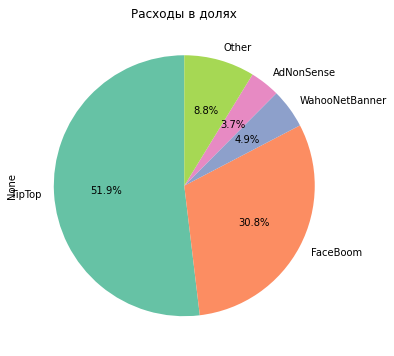

In [37]:
plt.figure(figsize=(12, 6))
top_channel_others.plot(kind='pie', autopct='%1.1f%%', startangle=90,colors=sns.color_palette('Set2'))
plt.title('Расходы в долях')
plt.show()

Как видно из таблицы и графика то львиную долю всего рекламного бюджета (больше 82.7%) потратили на два канала TipTop и FaceBomm. И если у канала FaceBoom самая высокая доля платящих пользователей, то у канала TipTop доля платящих пользователей на 4 месте, а он отъедает 51.9% всего бюджета.
Еще два канала WahooNetBanner, AdNonSense вместе 8.6%. Но у AdNonSense доля платящих пользователей 11.34% а у WahooNetBanner 5.30% ( в два раза меньше) но при этом бюджет больше.
Другими словами 91% процет бюджета приходится на 4 канала и 9% на все другие источники(которых 6).

In [38]:
grouped_costs = costs.groupby(['channel', 'dt'])['costs'].sum().reset_index()

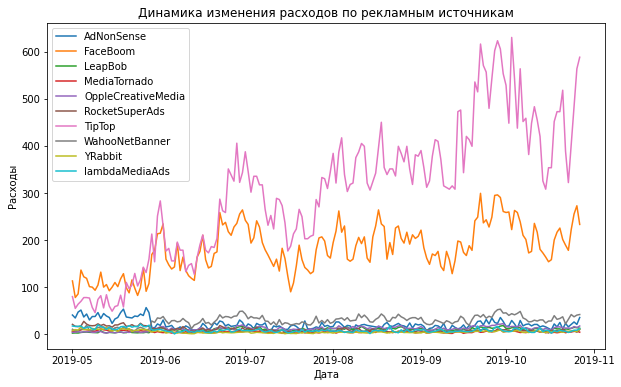

In [39]:
fig, ax = plt.subplots(figsize=(10, 6))

for channel in grouped_costs['channel'].unique():
    data = grouped_costs[grouped_costs['channel'] == channel]
    ax.plot(data['dt'], data['costs'], label=channel)

ax.legend()
ax.set_xlabel('Дата')
ax.set_ylabel('Расходы')
ax.set_title('Динамика изменения расходов по рекламным источникам')
plt.show()


В динамике можно увидеть рост инвестиций в эти же каналы (TipTop и FaceBoom)  в течение всего исследуемого периода, вызывает вопрос канал AdNonSense сначала мая 2019 и почти весь месяц в него активно инвестировали, а в с июня месяца серьезно снизили вливание в этот канал. 
тогда как остальные каналы привлечения остаются постоянными, а уровень инвестиций в них гораздо ниже и стабильнее.

Узнаем сколько в среднем стоило привлечение пользователя(CAC), по каждому каналу.

In [40]:
mean_cost_user = profiles.query('channel != "organic"').groupby('channel')['acquisition_cost'].mean().round(2).sort_values(ascending=False)
mean_cost_user

channel
TipTop                2.80
FaceBoom              1.11
AdNonSense            1.01
lambdaMediaAds        0.72
WahooNetBanner        0.60
RocketSuperAds        0.41
OppleCreativeMedia    0.25
MediaTornado          0.22
YRabbit               0.22
LeapBob               0.21
Name: acquisition_cost, dtype: float64

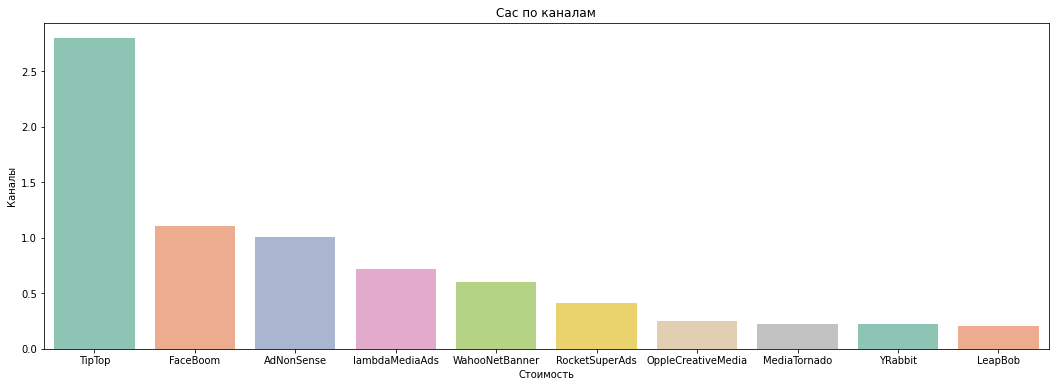

In [41]:
plt.figure(figsize=(18, 6))
sns.barplot(x=mean_cost_user.index, y=mean_cost_user.values, alpha=0.8, palette='Set2')

plt.title('Cac по каналам')
plt.xlabel('Стоимость')
plt.ylabel('Каналы')
plt.show()

Стоимость привлечения заметно разная от канала к каналу. Самая высокая у TipTop(на порядок выше ближайшего), FaceBoom, AdNonSense.(все три канала стоимость привлечения выше 1$). Потом группа где стоимость привлечения от 0.41$ до 0.72$, lambdaMediaAds, WahooNetBanner, RocketSuperAds. И третья группа где стоимость привлечения от 0.21$ до 0.25$, OppleCreativeMedia, MediaTornado,YRabbit, LeapBob.

In [60]:
print('Средний CAC по проекту:', profiles.query('channel != "organic"')['acquisition_cost'].mean().round(2))

Средний CAC по проекту: 1.13


### Вывод:
* Больше половины бюджета приходится на один канал TipTop, который по пользователям  и платящим пользователям находится на третьем месте, а по доле платящих пользователей на 4. Сумма привлечения пользователя на порядки опережает ближайший FaceBoom 2.80$ к 1.11$.
* Отметим что канал FaceBomm лучше всех привлекает пользователей и доля платящих пользователей самая высокая. Но и затраты по бюджету 30.8%  от общего.
* Динамика показывает что инвистиции в два канала TipTop и FaceBoom постоянно растут.
* Инвестиции в другие каналы стабильны и колеблются вогруг одних уровней.

## 5. Оцените окупаемость рекламы
* Используя графики LTV, ROI и CAC, проанализируйте окупаемость рекламы. Считайте, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. Необходимость включения в анализ органических пользователей определите самостоятельно.
* Проанализируйте окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
* Проверьте конверсию пользователей и динамику её изменения. То же самое сделайте с удержанием пользователей. Постройте и изучите графики конверсии и удержания.
* Проанализируйте окупаемость рекламы с разбивкой по устройствам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
* Проанализируйте окупаемость рекламы с разбивкой по странам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
* Проанализируйте окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.


Ответьте на такие вопросы:
* Окупается ли реклама, направленная на привлечение пользователей в целом?
* Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
* Чем могут быть вызваны проблемы окупаемости?
Напишите вывод, опишите возможные причины обнаруженных проблем и промежуточные рекомендации для рекламного отдела.

In [43]:
observation_date = datetime(2019, 11, 1).date()  # момент анализа
horizon_days = 14  # горизонт анализа 

In [44]:
profiles = profiles.query('channel != "organic"') # исключаю органический траффик переходов

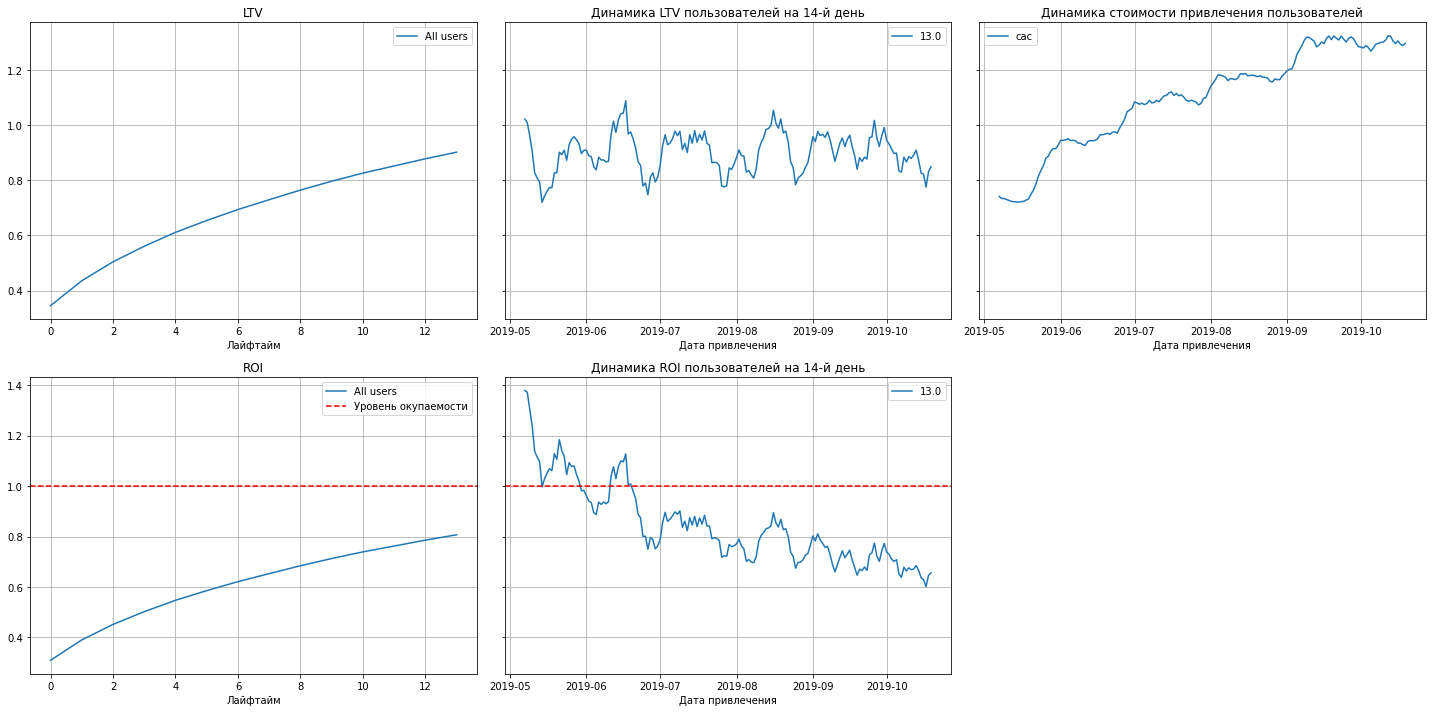

In [45]:
# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

По графикам можно сделать такие выводы:
* Реклама не окупается. ROI в конце недели — чуть выше 60%.
* CAC растет. Значит, увеличении рекламного бюджета, влияет на уровень окупаемости.
* ROI падает практически падает как растет CAC
* LTV достаточно стабилен
* Уровень окупаемости 1$ (Значит вся группа каналов у которых стоимость привлечения выше 1$ TipTop, FaceBoom, AdNonSense) без профита.

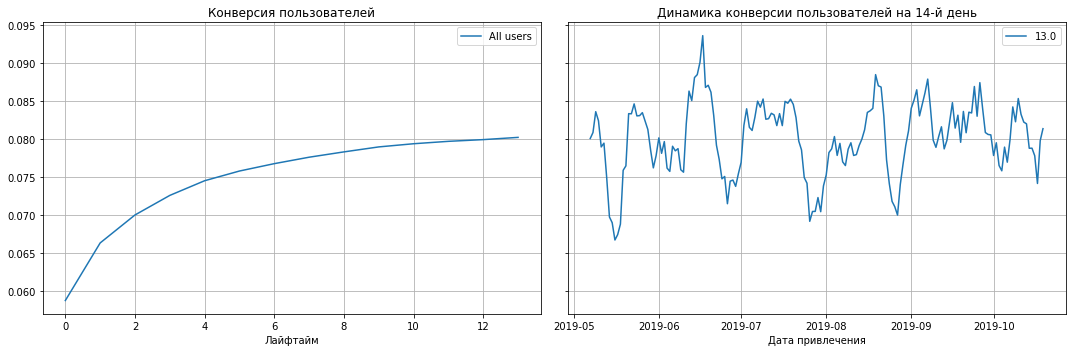

In [46]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

График  означает, что большинство пользователей не совершают действия, которые мы от них ожидаем. Довольно низкий показатель конверсии.

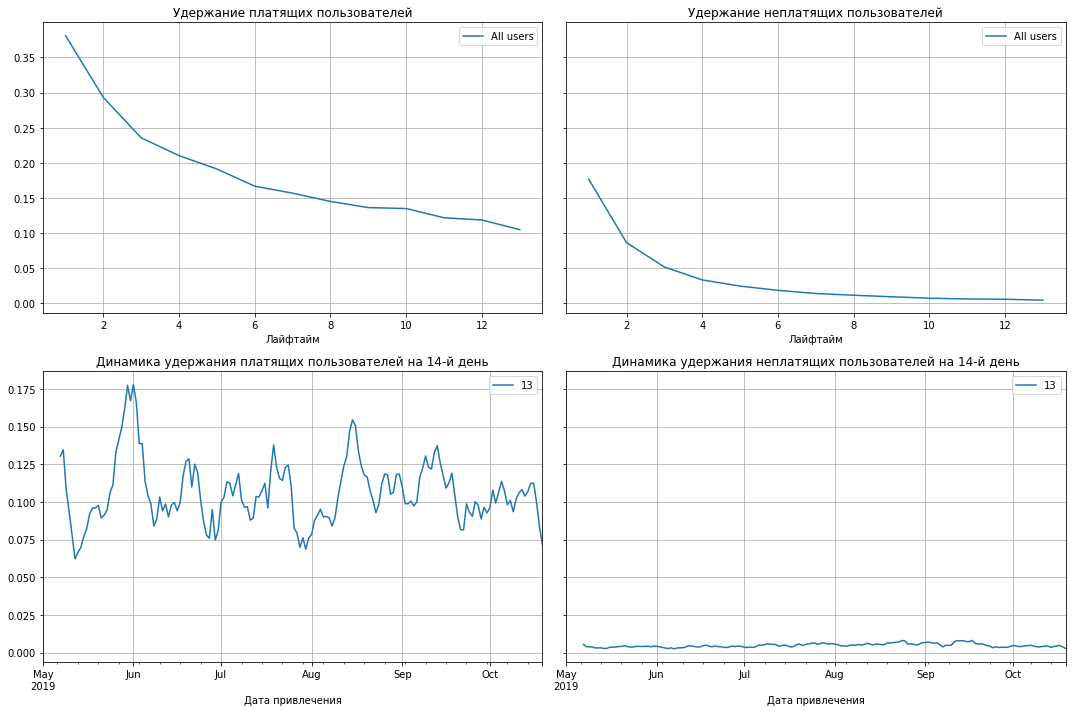

In [47]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days
)

plot_retention(retention_grouped, retention_history, horizon_days)

Для развлекательного приложения Retention Rate в 10%  довольно низкий показатель,  если наше приложение предназначено для постоянного использования.
Может потребоваться провести анализ и выявить причины, по которым пользователи не возвращаются на платформу.

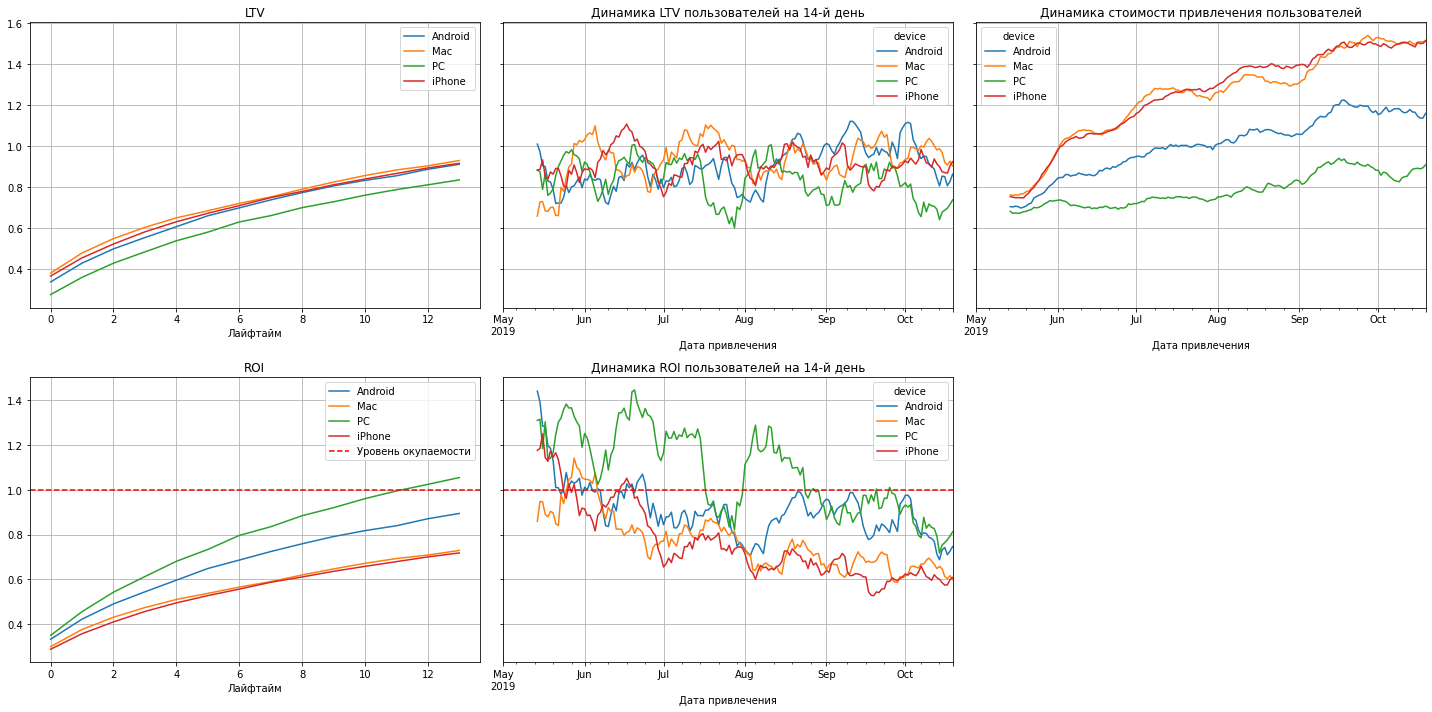

In [48]:
# считаем LTV и ROI по device
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = ['device']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

* Реклама окупается на владельцах PC , а Android, Mac и iPhone не окупется от слова совсем.
* Динамика привлечения растет для всех владельев device, но для iPhone и Mac CAC растет более динамично.
* ROI падает тоже для всех но особенно глубоко, опять же для iPhone и Mac
* LTV стабилен для всех

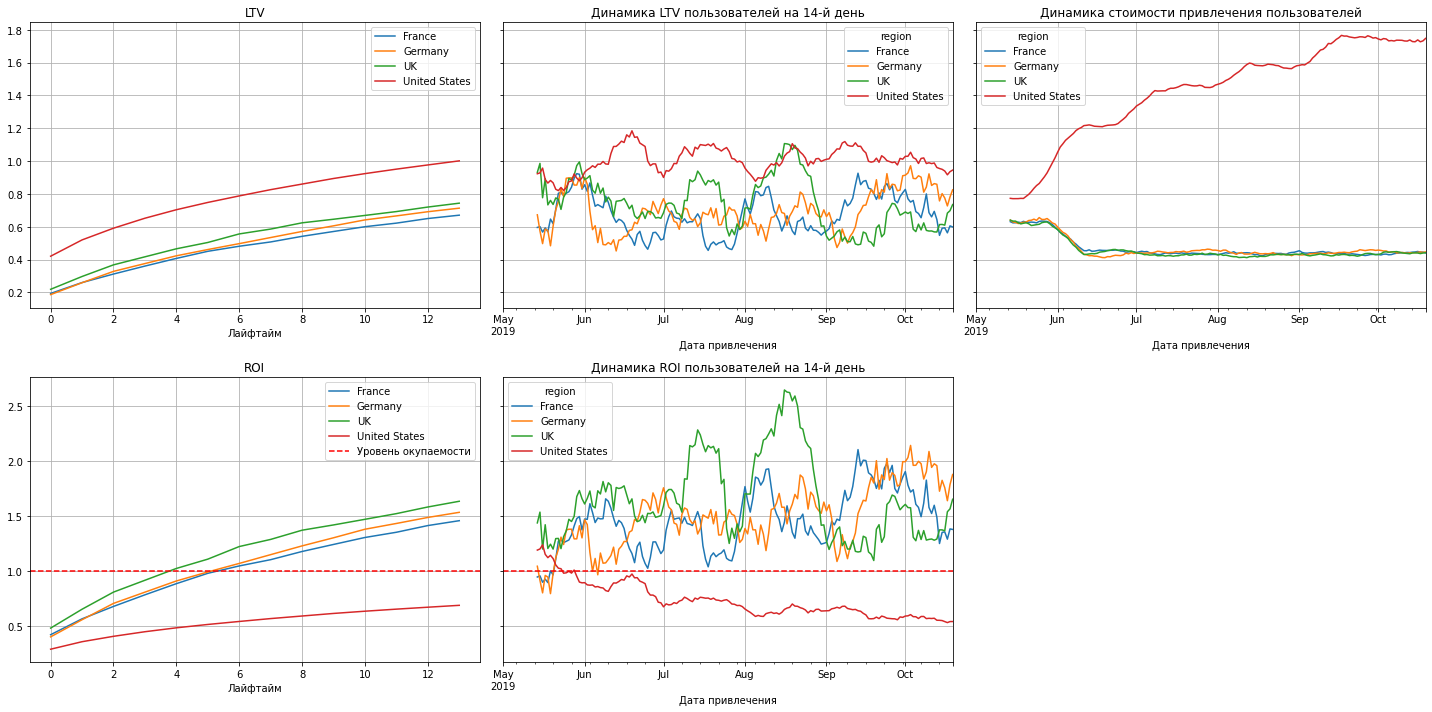

In [49]:
# считаем LTV и ROI по region
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions = ['region']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Вот и нашлась страна которая влияет на показатели это US,  хотя LTV у этих пользователей и самое высокое, но ROI опустилось до 55%, расходы на привлечение постоянно растут. Единственная страна которая не преодолевает порог окупаемости.И хотя эта самая большая страна как по количеству пользователей, по количеству платящих пользователй, а также по доле платящих пользователей. Но затраты на привлечение серьезно превышают уровень окупаемости. При уровне окупаемости в 1$, CAC 1.75$. 

Поэтому, попробую разобраться по региону USA отдельно.

In [50]:
profiles_usa = profiles.query("region == 'United States'") # профили по региону US

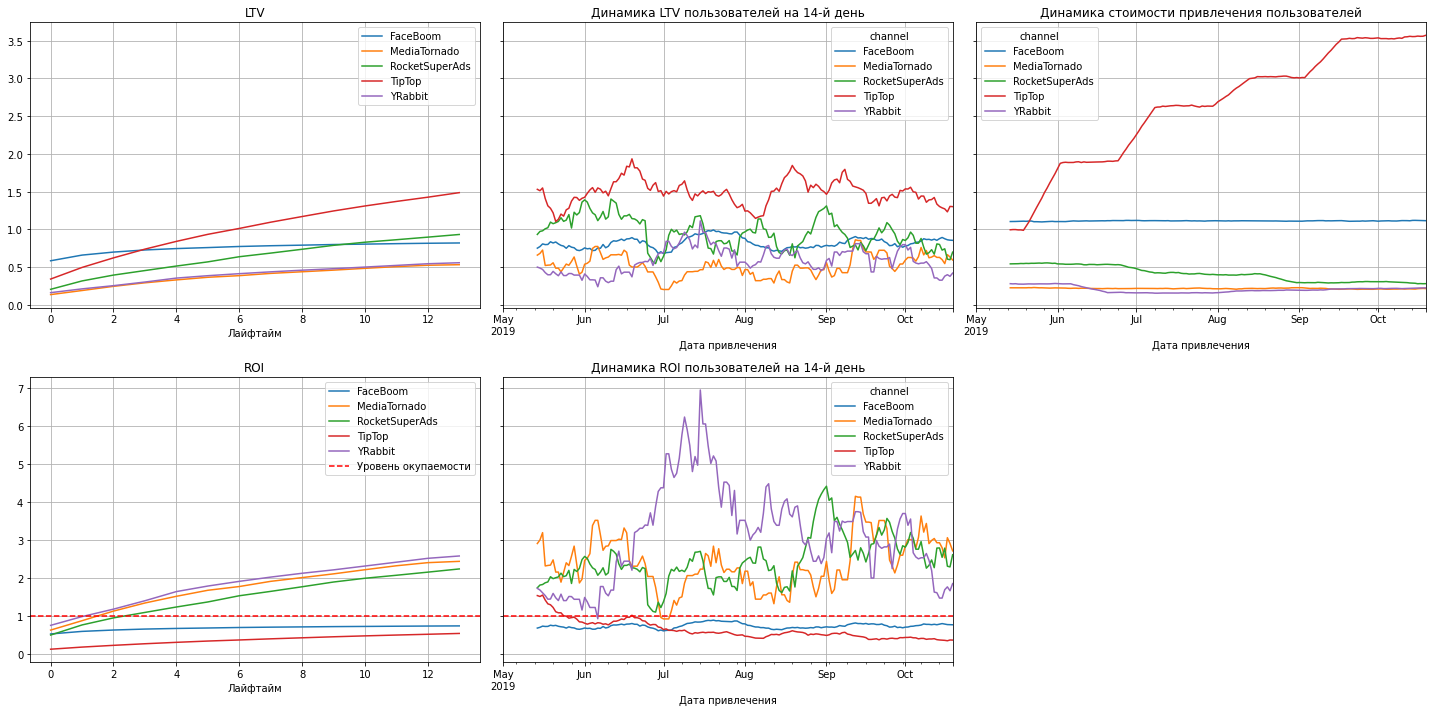

In [51]:
# считаем LTV и ROI по channel
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_usa, orders, observation_date, horizon_days, dimensions = ['channel']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

Все, как и предполагалась TipTop самый высокий LTV, CAC очень сильно растет, уровень окупаемости самый низкий, ROI падает до 50%. Ну и FaceBoom стабильный LTV, CAC на одном уровне, но уровень окупаемости преодолеть не может. ROI колеблется в районе 90%. Все остальные каналы практически сразу проходят точку безубыточности. 

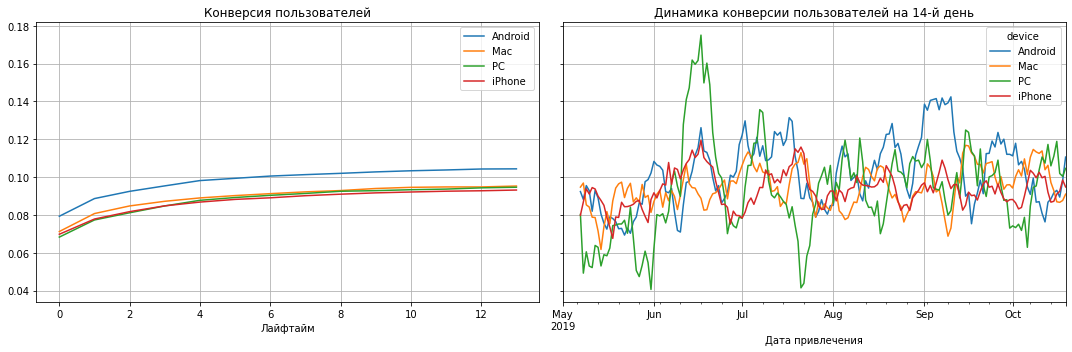

In [52]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_usa, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

Судя по графикам, все пользователи конвертируются хорошо, причём постоянно. Видимо, дело в удержаниию.
Пользователи Android стабильно выше всех и больше 10%.(что странно для US где iPhone захватил телефоны)
Самая низкая конверсия у iPhone.

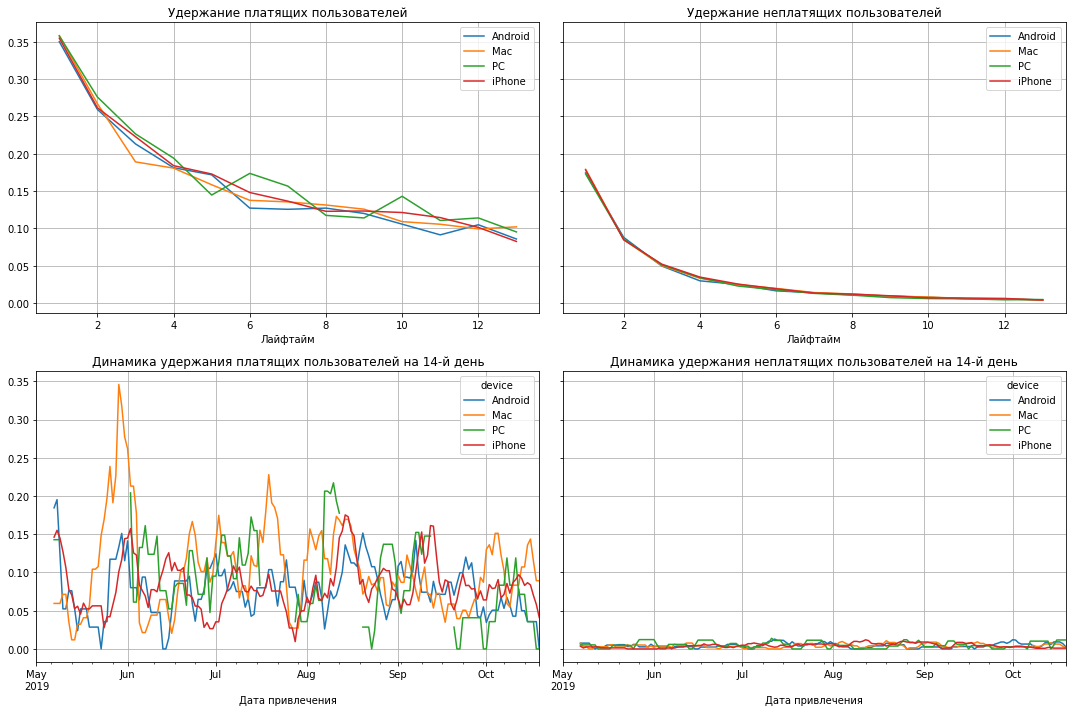

In [53]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_usa, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days) 

Пользователи всех устройств стабильно плохо удерживаются.
Удержание 14 дня на очень низких показателях. C удержанием в US дела плохи.
* Выявили два канала TipTop и FaceBoom, но есть еще канал AdNonSense, который не работает в US.(но имеет стоимость привлечения выше уровня окупаемости)
* И три канала MediaTornado, RocketSuperAds, YRabbit. Которые точку окупаемости проходят на второй день, стабильный LTV.
* Не все каналы работают в US

Вывод:
* Только пользователи, пришедшие в приложение из рекламных каналов TipTop и FaceBoom, приводят к убыткам. При этом TipTop демонстрирует самый высокий и стабильный LTV, но его САС постоянно растет. За каждый доллар, полученный от покупателей, требуется тратить 3,5 доллара на привлечение клиентов, что приводит к ROI, не превышающему 50%. 
* FaceBoom также не приносит прибыли и хотя его LTV выше, чем у некоторых других каналов, его САС все еще недостаточен для окупаемости и составляет 1,1 доллара.
* Три канала MediaTornado, RocketSuperAds, YRabbit. Которые точку окупаемости проходят на второй день, стабильный LTV.
* Хорошая конверсия, не плохая динамика.
* Плохое удержание пользователей.

Эти рекламные каналы используются только для привлечения клиентов из США, поэтому убыточность связана исключительно с расходами на рекламу в этом регионе.

Проработаем всех остальных в EU

In [54]:
profiles_eu = profiles.query('region != "United States"') # создаем профили европейцев

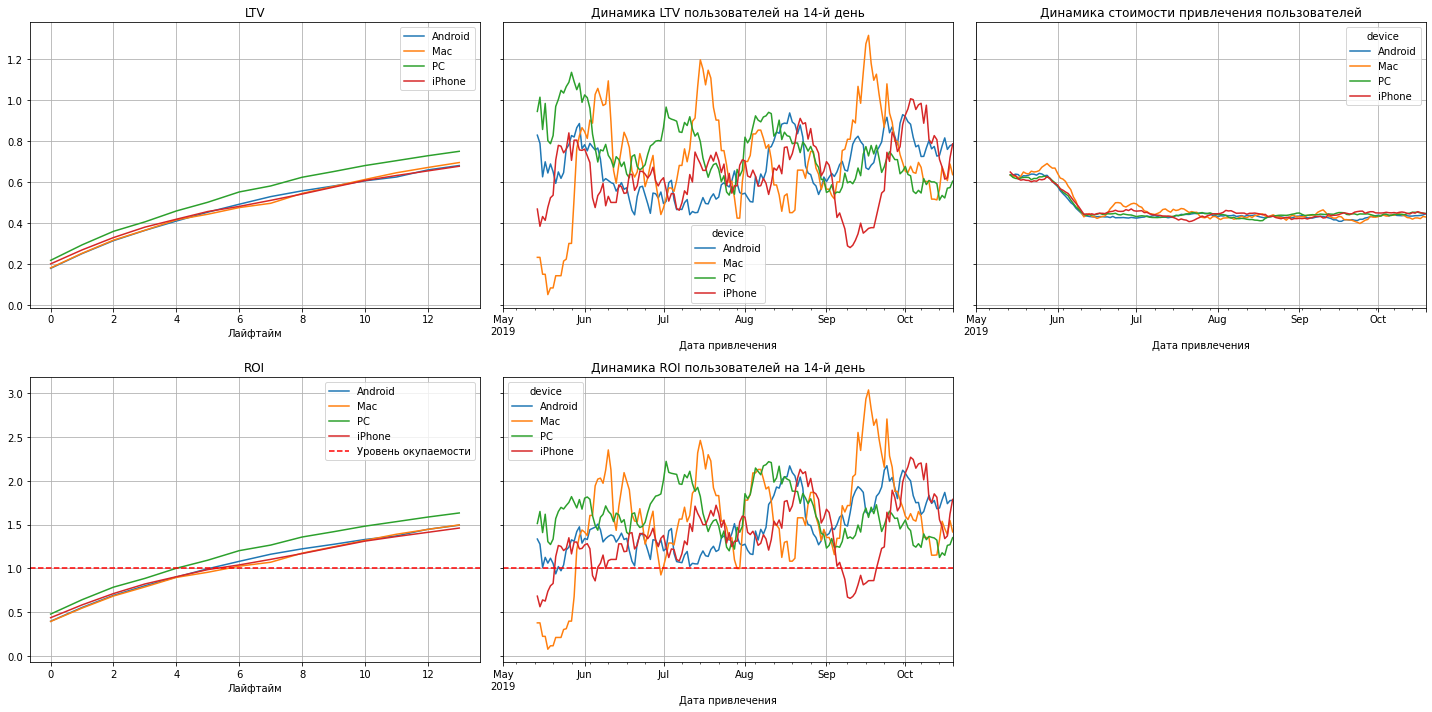

In [55]:
# считаем LTV и ROI по device
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_eu, orders, observation_date, horizon_days, dimensions = ['device']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

В Европе все девайсы проходят уровень окупаемости на 4-6 день. CAC сначала упал но выровнялся и стабилен.LTV повторяет ROI и хотя ROI iPhone тоже иногда падет ниже 100, все равно это позволяет окупать затраты на привлечение.

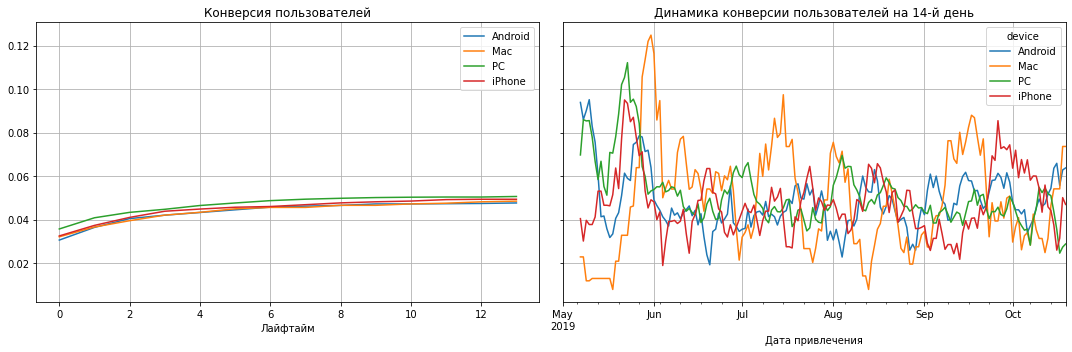

In [56]:
conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles_eu, orders, observation_date, horizon_days, dimensions=['device']
)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Судя по графикам с конверсией в Европе заметно хуже чем в Америке. Все пользователи примерно на одном плохом уровне 5%

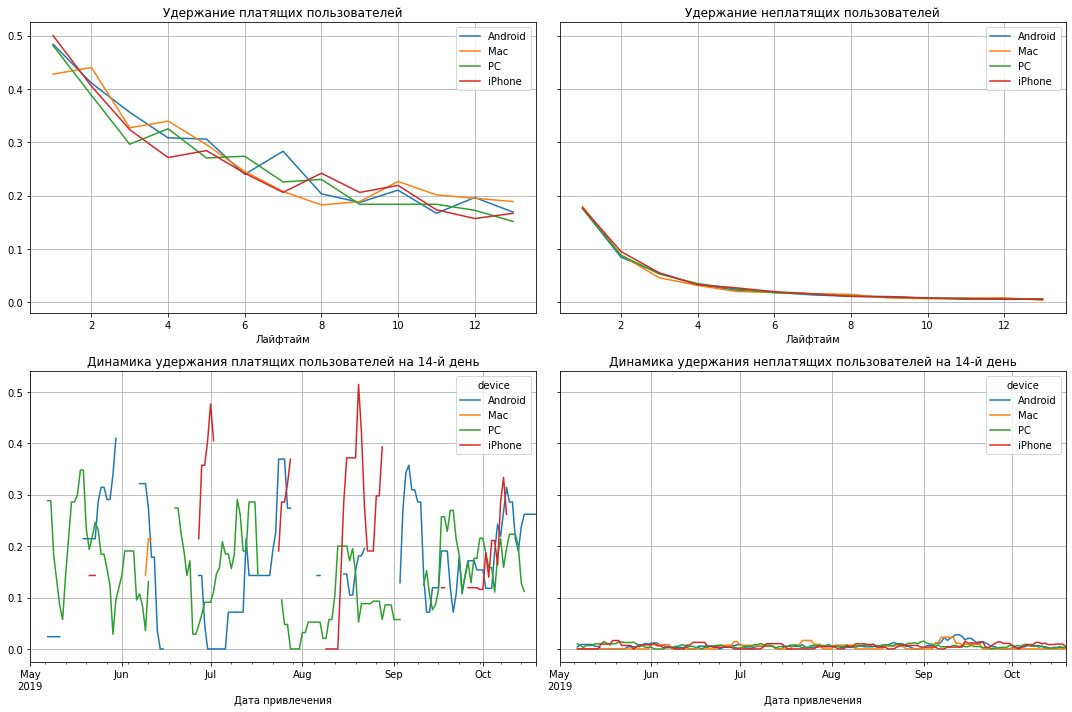

In [57]:
retention_raw, retention_grouped, retention_history = get_retention(
    profiles_eu, visits, observation_date, horizon_days, dimensions=['device']
)

plot_retention(retention_grouped, retention_history, horizon_days)

Кофициент удержания  в Европейских странах в два раза выше чем в Штатах.

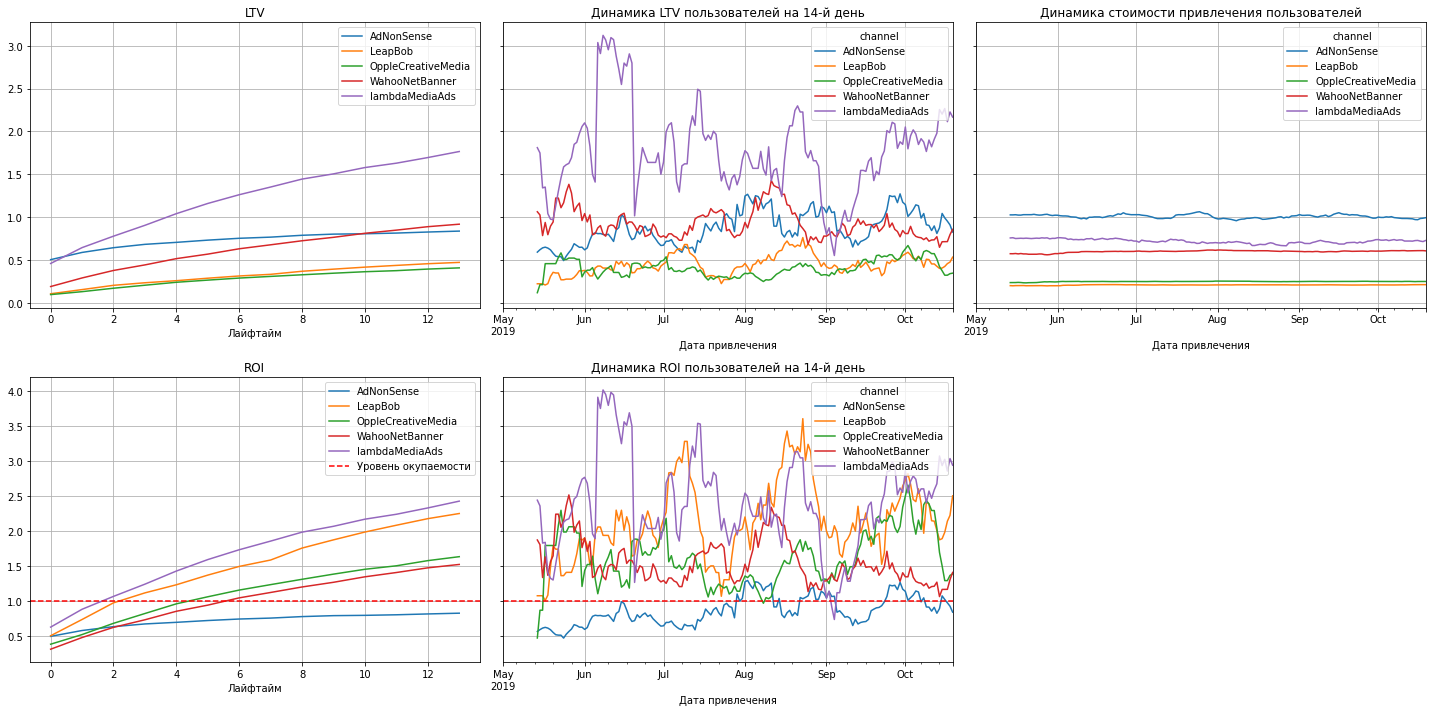

In [58]:
# считаем LTV и ROI по channel
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles_eu, orders, observation_date, horizon_days, dimensions = ['channel']
)
# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

А вот и канал AdNonSense, единственный в Европе через который затраты на привлечение не окупаются.Хотя на некоторых периодах времени ROI поднимается выше 100, но вообщем канал привлечения не работает как нужно.
* Выяснили что каналы привлечения в Европе и Штатах разные и не пересекаются.


Вывод:
* В Европе уровень окупаемости устройств достигается на 4-6 день, при этом САС сначала снижается, но затем стабилизируется. LTV повторяет ROI, и хотя ROI для iPhone может падать ниже 100, это все равно позволяет окупать затраты на привлечение.
* С другой стороны, конверсия в Европе ниже, чем в Америке, и все пользователи находятся на примерно одном уровне около 5%. Также было выявлено, что канал привлечения AdNonSense в Европе не окупается, хотя ROI на некоторых периодах времени поднимается выше 100.
* Четыре канала LeapBob, OppleCreativeMedia, WahooNetBanner, LambdaMediaAds имеют хорошие показатели окупаемости динамику LTV и показатели ROI.
* Низкая конверсия
* Коэффициент удержания в Европе в два раза больше чем в USA.
* Важно отметить, что каналы привлечения в Европе и США разные и не пересекаются, что является одной из причин различий в показателях.

Общий вывод:

Данные содержат информацию о новых пользователях приложения, зарегистрировавшихся с 1 мая 2019 года по 27 октября 2019 года, их покупках за этот период, а также статистике рекламных расходов. Для удобства анализа, данные были предварительно обработаны: наименования столбцов были исправлены, а тип данных в столбцах, содержащих дату, был изменен с object на datetime, а также данные были проверенны на пропуски и дублирущие значения.

Из анализа данных видно, что не все рекламные каналы и регионы оказывают положительное влияние на окупаемость рекламы. Некоторые каналы, такие как TipTop и FaceBoom в США и AdNonSense в Европе, не окупаются вообще, что приводит к убыткам. В то же время, некоторые каналы в регионах, такие как MediaTornado, RocketSuperAds, YRabbit в США и LeapBob, OppleCreativeMedia, WahooNetBanner, LambdaMediaAds в Европе, имеют хорошие показатели окупаемости. 


Не все рекламные каналы и регионы оказывают положительное влияние на окупаемость рекламы. Некоторые каналы не окупаются вообще, что приводит к убыткам. Однако, есть и каналы, которые окупаются и приносят прибыль.
Реклама, направленная на привлечение пользователей в США через TipTop и FaceBoom, а также в Европе через AdNonSense, оказывает негативное влияние на окупаемость рекламы. Также отмечается низкая конверсия в Европе, что может привести к снижению окупаемости.
Проблемы окупаемости могут быть вызваны неправильным выбором каналов рекламы, низкой конверсией, недостаточным удержанием пользователей, высокими расходами на рекламу.
Возможные причины обнаруженных проблем могут быть связаны с неправильным выбором каналов рекламы и низкой конверсией. Также высокие расходы на рекламу могут привести к низкой окупаемости. Для решения проблемы необходимо более тщательно анализировать данные, определять наиболее эффективные каналы и регионы, а также работать над повышением конверсии и удержанием пользователей.